In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
from torch.cuda.amp import GradScaler, autocast

In [3]:
import seaborn as sns
import albumentations as A
from tqdm.notebook import tqdm

## Load DataFrame with Pathing

In [4]:
df = pd.read_csv('data/POC_imagedata.csv')

In [5]:
df.head()

,Country,Latitude,Longitude,Pano_Id,Path
0,Spain,36.477286,-5.880578,mnPCQWYwG-MIUV64ybl23g,data/images/Spain/0000/
1,Spain,37.600117,-4.341563,cXqaOBEMHANps9ZENoLozw,data/images/Spain/0001/
2,Spain,42.870488,-1.381516,RHuZZGXpb4levD1LK8Wtsw,data/images/Spain/0002/
3,Spain,41.296693,-3.603524,si-40KyaaKHFGdvy12nSIg,data/images/Spain/0003/
4,Spain,39.024927,-3.977601,wniI8AxaJ2gBC7q1GjV7GQ,data/images/Spain/0004/


In [6]:
#df = df.sample(1000)

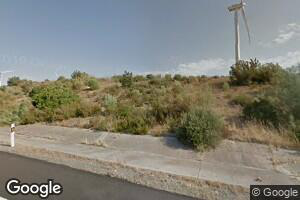

In [7]:
Image.open(df.Path.iloc[0] + 'N.jpg')

## Create Train / Validation Sets

In [8]:
train, val = train_test_split(df, test_size=0.20, stratify=df.Country.values)

In [9]:
val, test = train_test_split(val, test_size=0.5, stratify=val.Country.values)

In [10]:
train.shape

(2400, 5)

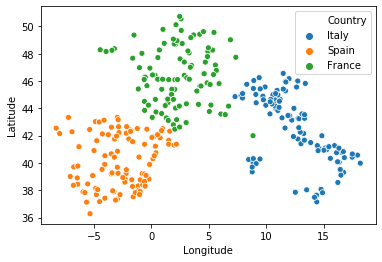

In [11]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='Country')

## Dataset

In [12]:
MAPPING = {'Spain': 0, # Spain
           'France': 1, # France
           'Italy': 2} # Italy

In [13]:
def img_to_np(fullpath):
    x = cv2.imread(fullpath).astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [14]:
def stitch_panos(path):
    return np.concatenate([img_to_np(path + direction + '.jpg') for direction in 'NESWN'], axis=1)

In [15]:
def get_xy(path, y_map):
    x = stitch_panos(path)
    y = y_map[path[12: 12 + path[12:].find('/')]]
    return x, y

In [16]:
x, y = get_xy(train.Path.iloc[0], MAPPING)

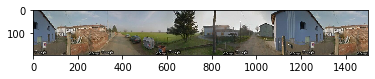

In [17]:
plt.imshow(x)

In [18]:
x.shape, y

((200, 1500, 3), 2)

#### Data Augmentation Functions

In [19]:
transforms = A.Compose([
        A.RandomCrop(height=150, width=1200),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.15),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=12.5, p=0.4),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.2),
        A.Normalize()
    ])

no_transforms = A.Compose([
        A.RandomCrop(height=150, width=1200),
        A.Normalize()
])

In [20]:
def min_max_scale(img):
    max_, min_ = img.max(), img.min()
    return (img - min_) / (max_ - min_)

(150, 1200, 3)


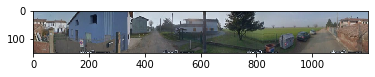

In [21]:
aug = transforms(image=x)['image']
print(aug.shape)
plt.imshow(min_max_scale(aug))

(150, 1200, 3)


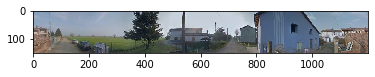

In [22]:
no_aug = no_transforms(image=x)['image']
print(no_aug.shape)
plt.imshow(min_max_scale(no_aug))

In [23]:
class GeoDataset(Dataset):
    def __init__(self, df, transform=False):
        self.paths = [p for p in df.Path.values]
        self.transform = transform
        self.random_init()
        
    def random_init(self):
        self.random = np.random.rand(len(self.paths), 4)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        x, y = get_xy(self.paths[idx], MAPPING)
        
        if self.transform:
            x = transforms(image=x)['image']
        else:
            x = no_transforms(image=x)['image']
        
        x = np.rollaxis(x, 2)
        return x, y

In [24]:
train_ds = GeoDataset(train, transform=True)
valid_ds = GeoDataset(val)
test_ds = GeoDataset(test)

In [25]:
x, y = train_ds[1]
x.shape, y

((3, 150, 1200), 1)

## Model

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 128), nn.ReLU(), 
                                        nn.Dropout(0.4), nn.Linear(128, 3))
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(self.dropout(x))
        return x

In [27]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y, reduction='sum')
            _, pred = torch.max(out, 1)
            correct += pred.eq(y).sum().item()
            sum_loss += loss.item()
            total += batch
    return sum_loss/total, correct/total

In [28]:
def train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer2(model, lrs[0])
    scaler = GradScaler()
    prev_val_acc = 0.0
    path = ''
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer2(optimizer, [lr/25, lr/10, lr])
            batch = y.shape[0]
            
            optimizer.zero_grad()
            with autocast():
                x = x.cuda()
                y = y.cuda()
                out = model(x)
                loss = F.cross_entropy(out, y, reduction='sum')
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            #loss.backward()
            #optimizer.step()
            total += batch
            sum_loss += loss.item()
            idx += 1
            pbar.update()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.75:
                path = "data/models/model_resnet18_stitch_loss_{0:.0f}.pth".format(100*val_acc)
                save_model(model, path)
                print(path)
    return path

In [29]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [30]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [31]:
def create_optimizer2(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/20},
              {'params': model.features2.parameters(), 'lr': lr0/10},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=9e-5)

def update_optimizer2(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [32]:
batch_size = 96
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [33]:
model = Net().cuda()

In [34]:
val_metrics(model, valid_dl)

(1.136724894841512, 0.3333333333333333)

In [35]:
best_path = train_epochs(model, train_dl, valid_dl, max_lr=0.00075, epochs=40)

train_loss 1.125 val_loss 1.083 val_acc 0.387
train_loss 1.114 val_loss 1.042 val_acc 0.453
train_loss 1.066 val_loss 0.984 val_acc 0.553
train_loss 1.010 val_loss 0.905 val_acc 0.600
train_loss 0.929 val_loss 0.799 val_acc 0.653
train_loss 0.853 val_loss 0.756 val_acc 0.667
train_loss 0.794 val_loss 0.722 val_acc 0.670
train_loss 0.741 val_loss 0.680 val_acc 0.700
train_loss 0.694 val_loss 0.651 val_acc 0.720
train_loss 0.627 val_loss 0.594 val_acc 0.747
train_loss 0.549 val_loss 0.588 val_acc 0.750
train_loss 0.528 val_loss 0.620 val_acc 0.747
train_loss 0.485 val_loss 0.593 val_acc 0.770
data/models/model_resnet18_stitch_loss_77.pth
train_loss 0.461 val_loss 0.794 val_acc 0.727
train_loss 0.381 val_loss 0.646 val_acc 0.743
train_loss 0.369 val_loss 0.668 val_acc 0.767
train_loss 0.334 val_loss 0.627 val_acc 0.750
train_loss 0.321 val_loss 0.684 val_acc 0.763
train_loss 0.292 val_loss 0.763 val_acc 0.743
train_loss 0.254 val_loss 0.710 val_acc 0.763
train_loss 0.235 val_loss 0.694 va

In [36]:
best_path

'data/models/model_resnet18_stitch_loss_81.pth'

## Test Set Evaluation

In [37]:
best_model = Net().cuda()
load_model(best_model, best_path)

In [38]:
test.head()

,Country,Latitude,Longitude,Pano_Id,Path
2821,Italy,45.565313,11.972374,-mOhfaeLIybAwZZ-mO-47w,data/images/Italy/0821/
2162,Italy,42.768624,11.978328,YWgacDCpwVrrDyd4WCvnYw,data/images/Italy/0162/
573,Spain,39.119206,-3.770634,zE5yBxFBkv9ZUDDeaJbr5A,data/images/Spain/0573/
1005,France,47.120321,-0.147486,59_dVb3XGJ4u7WIpZdyxyw,data/images/France/0005/
1203,France,43.642540,5.815277,L2z5cSwGnCOpSXrPv6BcJg,data/images/France/0203/


In [39]:
rev_map = {v: k for k,v in MAPPING.items()}
rev_map

{0: 'Spain', 1: 'France', 2: 'Italy'}

In [40]:
preds = []
with torch.no_grad():
    best_model.eval()
    for x, y in test_dl:
        out = best_model(x.cuda().float())
        _, pred = torch.max(out, 1)
        pred = pred.cpu().detach().numpy()
        preds += [rev_map[p] for p in pred]

In [41]:
test['predictions'] = preds

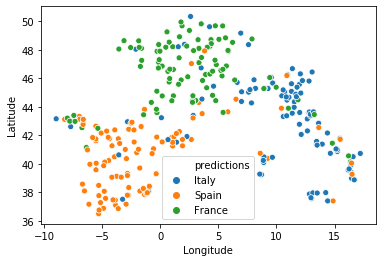

In [42]:
sns.scatterplot(x='Longitude', y='Latitude', data=test, hue='predictions')

In [43]:
(test.Country == test.predictions).sum() / len(test)

0.81